[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Komatsu-T/Samples/blob/main/deep_learning/computer_vision/pixel_CNN/Conditional_pixel_CNN.ipynb)

# Sample of conditional pixel CNN
### Dataset: MNIST (gray scale image)
### Image generation: Random (Conditional)

### Import Libraries

In [25]:
!pip install torchinfo

In [26]:
# --------------------------------------------------
# Libraries
# --------------------------------------------------
import pandas as pd
import numpy as np
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10, STL10
from torchinfo import summary

### GPU

In [27]:
# --------------------------------------------------
# Device
# --------------------------------------------------
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

if use_cuda:
    !nvidia-smi

cuda
Sat Aug 17 09:19:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0              27W /  70W |   4031MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+--------------------

### Download MNIST dataset

In [28]:
# --------------------------------------------------
# Dataset
# --------------------------------------------------

# Parameter
batch_size = 256

# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Datset
train_dataset = torchvision.datasets.MNIST(root = './train', train = True, transform = transform, download = True)
test_dataset = torchvision.datasets.MNIST(root = './test', train = False, transform = transform, download = True)

# DataLoader
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = True)

### Training

In [29]:
# --------------------------------------------------
# Model
# --------------------------------------------------

class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        """
        mask_type
            A: Filters that masks its own pixels
            B: Filters that does not mask its own pixels
        """
        super().__init__(*args, **kwargs)
        self.register_buffer("mask", self.weight.data.clone())
        self.mask.fill_(1)
        height = self.weight.size()[2]
        width = self.weight.size()[3]
        if mask_type == "A":
            self.mask[:, :, height//2, width//2:] = 0
            self.mask[:, :, height//2+1:] = 0
        elif mask_type == "B":
            self.mask[:, :, height//2, width//2+1:] = 0
            self.mask[:, :, height//2+1:] = 0
        else:
            raise ValueError("Parameter 'mask_type' must be 'A' or 'B'.")

    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)

class ConditionalMaskedConv2d(MaskedConv2d):
    def __init__(self, mask_type, n_classes, *args, **kwargs):
        super().__init__(mask_type, *args, **kwargs)
        self.n_classes = n_classes
        self.V = nn.Parameter(torch.randn(kwargs['out_channels'], self.n_classes))

    def forward(self, x, class_label):
        # Masked convolution
        out = super().forward(x)
        size = out.size()
        # Onehot class label
        onehot_label = np.zeros((len(class_label.cpu()), self.n_classes))
        onehot_label[np.arange(len(class_label.cpu())), class_label.cpu()] = 1
        onehot_label = torch.tensor(onehot_label).float().to(device)
        # Label embedding (n_channels * minibatch_size)
        label_embedding = self.V@onehot_label.T
        # Add label embedding to masked convoluted feature map
        out = out.view(size[0], size[1], size[2]*size[3]) + (label_embedding.T.unsqueeze(-1))
        out = out.view(size)
        return out

class ConditionalPixelCNN(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels, n_layers, n_classes):
        super().__init__()
        # Input layer
        self.input_layer = nn.ModuleList()
        self.input_layer.append(ConditionalMaskedConv2d("A", n_classes, in_channels = in_channels, out_channels = hidden_channels, kernel_size = 7, stride = 1, padding = 3, bias = False))
        self.input_layer.append(nn.BatchNorm2d(hidden_channels))
        self.input_layer.append(nn.ReLU())
        # Stacked layer
        self.stacked_layers = nn.ModuleList()
        for i in range(n_layers):
            self.stacked_layers.append(ConditionalMaskedConv2d('B', n_classes, in_channels = hidden_channels, out_channels = hidden_channels, kernel_size = 7, stride = 1, padding = 3, bias = False))
            self.stacked_layers.append(nn.BatchNorm2d(hidden_channels))
            self.stacked_layers.append(nn.ReLU())
        # Output layer
        self.output_layer = ConditionalMaskedConv2d('B', n_classes, in_channels = hidden_channels, out_channels = out_channels, kernel_size = 1, stride = 1, padding = 0)

    def forward(self, x, class_label):
        out = x
        # Input layer
        for layer in self.input_layer:
            if isinstance(layer, ConditionalMaskedConv2d):
                out = layer(out, class_label)
            else:
                out = layer(out)
        # Stacked layer
        for layer in self.stacked_layers:
            if isinstance(layer, ConditionalMaskedConv2d):
                out = layer(out, class_label)
            else:
                out = layer(out)
        # Output layer
        out = self.output_layer(out, class_label)
        return out

In [30]:
# --------------------------------------------------
# Model instantiation
# --------------------------------------------------

# Parameters
in_channels = 1
out_channels = 256
hidden_channels = 64
n_layers = 7
n_classes = 10

# Model
model = ConditionalPixelCNN(in_channels, out_channels, hidden_channels, n_layers, n_classes)
model = model.to(device)

# Total params
params = 0
for p in model.parameters():
    if p.requires_grad:
        params += p.numel()
print(f"Total trainable params: {params}")

Total trainable params: 1433408


In [31]:
# --------------------------------------------------
# Other training components
# --------------------------------------------------

# Optimizer
lr = 0.001
weight_decay = 0
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)

# Loss function
criterion = nn.CrossEntropyLoss()

In [32]:
# --------------------------------------------------
# Training
# --------------------------------------------------

# Settings
epochs = 50
train_loss_minibatch = []
train_loss_epoch = []
test_loss_epoch = []

# Training
for epoch in range(epochs):

    with tqdm(train_loader) as pbar:
        pbar.set_description(f'[Epoch {epoch+1}/{epochs}]')

        # Training step
        model.train()
        for x, y in pbar:
            # Device
            x = x.to(device)
            y = y.to(device)
            # 0-1 scale image -> 0-255 scale image
            target = (x[:,0]*255).long()
            # Parameter update
            output = model(x, y)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_minibatch.append(loss.item())

        # Evaluation step
        model.eval()
        with torch.no_grad():
            # Train loss
            losses = []
            for x, y in train_loader:
                x = x.to(device)
                y = y.to(device)
                target = (x[:,0]*255).long()
                output = model(x, y)
                loss = criterion(output, target)
                losses.append(loss.item())
            train_loss_epoch.append(np.mean(losses))

            # Test loss
            losses = []
            for x, y in test_loader:
                x = x.to(device)
                y = y.to(device)
                target = (x[:,0]*255).long()
                output = model(x, y)
                loss = criterion(output, target)
                losses.append(loss.item())
            test_loss_epoch.append(np.mean(losses))

[Epoch 50/50]: 100%|██████████| 235/235 [01:32<00:00,  2.53it/s]


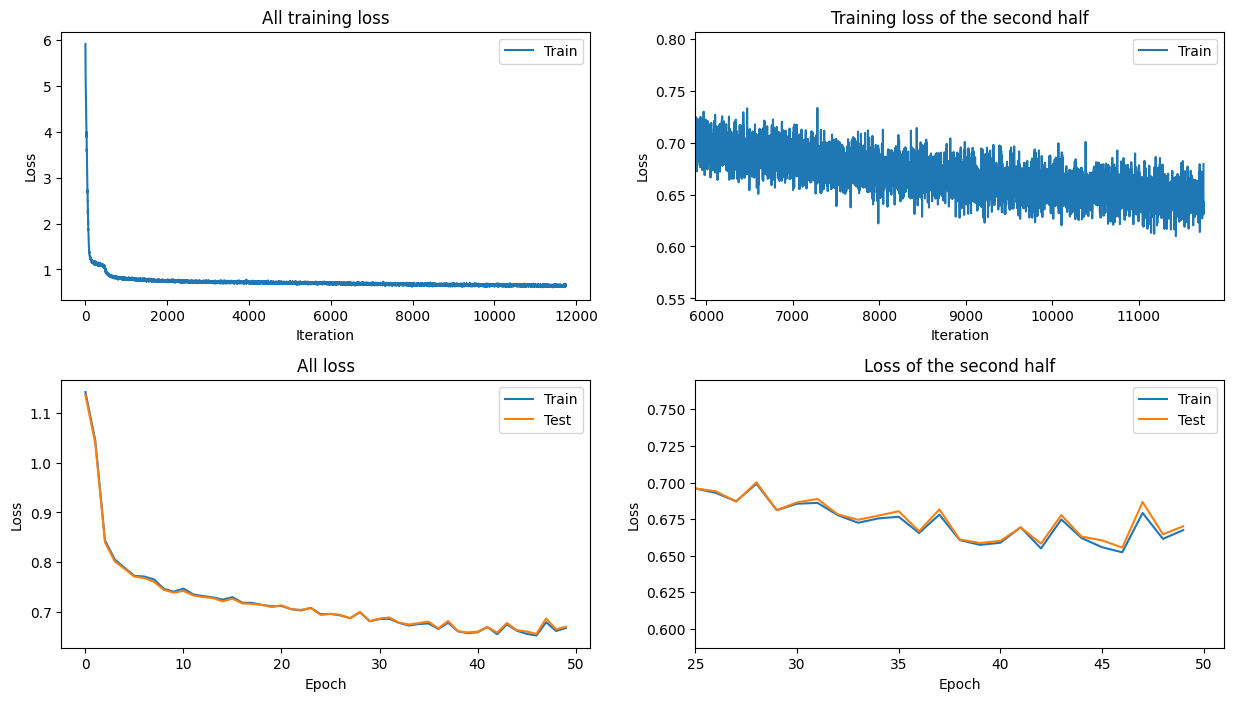

In [33]:
# --------------------------------------------------
# Loss plot
# --------------------------------------------------

fig, ax = plt.subplots(2, 2, figsize = (15, 8))
ax = ax.ravel()
plt.subplots_adjust(hspace = 0.3)

# Loss of training iterations
ax[0].plot(train_loss_minibatch, label = 'Train')
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].set_title("All training loss")
ax[1].plot(train_loss_minibatch, label = 'Train')
ax[1].set_xlim(len(train_loss_minibatch)//2, len(train_loss_minibatch)*1.02)
ax[1].set_ylim(min(train_loss_minibatch[len(train_loss_minibatch)//2:])*0.9, max(train_loss_minibatch[len(train_loss_minibatch)//2:])*1.1)
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Loss")
ax[1].legend()
ax[1].set_title("Training loss of the second half")

# Loss of train and test per epoch
ax[2].plot(train_loss_epoch, label = 'Train')
ax[2].plot(test_loss_epoch, label = 'Test')
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Loss")
ax[2].legend()
ax[2].set_title("All loss")
ax[3].plot(train_loss_epoch, label = 'Train')
ax[3].plot(test_loss_epoch, label = 'Test')
ax[3].set_xlim(len(train_loss_epoch)//2, len(train_loss_epoch)*1.02)
ax[3].set_ylim(min(min(train_loss_epoch[len(train_loss_epoch)//2:]), min(test_loss_epoch[len(test_loss_epoch)//2:]))*0.9,
               max(max(train_loss_epoch[len(train_loss_epoch)//2:]), max(test_loss_epoch[len(test_loss_epoch)//2:]))*1.1)
ax[3].set_xlabel("Epoch")
ax[3].set_ylabel("Loss")
ax[3].legend()
ax[3].set_title("Loss of the second half")
plt.show()

### Conditional image generation

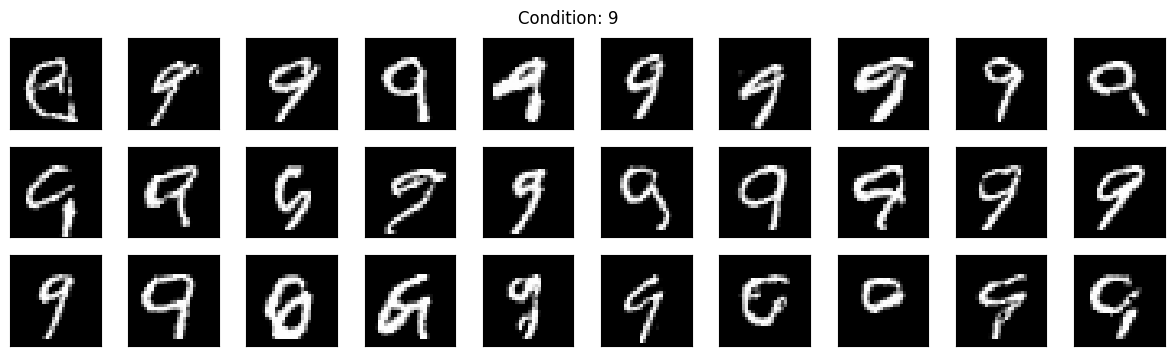

In [64]:
# --------------------------------------------------
# Conditional image generation
# --------------------------------------------------

def image_generation(model: ConditionalPixelCNN,
                     device: torch.device,
                     target: int,
                     n_images = 30, n_channesl = 1, iamge_hieght = 28, image_width = 28, n_classes = 10):
    # Initialize
    generated_image = torch.Tensor([0 for i in range(n_images*n_channesl*iamge_hieght*image_width)])
    generated_image = generated_image.view(n_images, n_channesl, iamge_hieght, image_width)
    generated_image = generated_image.to(device)
    labels = torch.Tensor([target for i in range(n_images)]).long().to(device)

    # Generation
    model.eval()
    with torch.no_grad():
        for h in range(iamge_hieght):
            for w in range(image_width):
                output = model(generated_image, labels)
                probability = F.softmax(output[:, :, h, w], dim = 1)
                generated_image[:, :, h, w] = torch.multinomial(probability, 1)/255

    # Plot
    fig, ax = plt.subplots(3, 10, figsize = (15, 4))
    ax = ax.ravel()
    for i in range(n_images):
        ax[i].imshow(generated_image[i].permute(1, 2, 0).cpu(), cmap = 'gray')
        ax[i].tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)
    plt.suptitle(f"Condition: {target}", y = 0.95)
    plt.show()
    return generated_image

# Show image
target = 9
_ = image_generation(model, device, target)